### 04 — Neural Collaborative Filtering (NCF / MLP)
Train a PyTorch MLP-based recommender using the processed splits:
`data/processed/ratings_train.csv`, `ratings_valid.csv`, `ratings_test.csv`.

**Notes**
- We build user/item id maps from the **union** of all splits to keep indices consistent.
- Model: user & item embeddings → MLP → rating (regression).
- Metrics: RMSE, MAE on validation & test.
- Works on CPU, CUDA, or Apple Silicon (MPS).

In [96]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

BASE = Path.cwd().parent
sys.path.append(str(BASE / 'src'))

from ncf_model import (
    build_ncf_model,
    encode_splits,
    RatingsDataset,
    run_epoch,
    build_seen_items,
    recommend_topk,
)

PROC = BASE / 'data' / 'processed'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


Device: cpu


In [106]:
train_df = pd.read_csv(PROC / "ratings_train.csv")
valid_df = pd.read_csv(PROC / "ratings_valid.csv")
test_df  = pd.read_csv(PROC / "ratings_test.csv")

for name, df in [("train", train_df), ("valid", valid_df), ("test", test_df)]:
    print(f"{name} -> shape={df.shape}  users={df.userId.nunique()}  items={df.movieId.nunique()}")


train -> shape=(31316, 7)  users=479  items=426
valid -> shape=(3669, 7)  users=479  items=426
test -> shape=(3669, 7)  users=479  items=426


In [98]:
train_enc, valid_enc, test_enc, user2idx, item2idx = encode_splits(train_df, valid_df, test_df)
user2idx_map = user2idx.to_dict()
item2idx_map = item2idx.to_dict()

n_users = len(user2idx)
n_items = len(item2idx)
print('n_users:', n_users, 'n_items:', n_items)


n_users: 479 n_items: 426


In [ ]:
BATCH_SIZE = 2048

train_dataset = RatingsDataset(train_enc)
valid_dataset = RatingsDataset(valid_enc)
test_dataset = RatingsDataset(test_enc)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


In [102]:
EPOCHS = 10
LR = 1e-3
EMB = 64

model = build_ncf_model(n_users, n_items, emb_dim=EMB, device=device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

history = {'train_loss': [], 'val_loss': [], 'val_rmse': [], 'val_mae': []}
best_val = float('inf')
best_ep = None

model_path = BASE / 'models' / 'ncf_best.pth'
model_path.parent.mkdir(parents=True, exist_ok=True)

for ep in range(1, EPOCHS + 1):
    tr_loss, tr_rmse, tr_mae = run_epoch(model, train_loader, criterion, optimizer, device=device)
    val_loss, val_rmse, val_mae = run_epoch(model, valid_loader, criterion, optimizer=None, device=device)
    history['train_loss'].append(tr_loss)
    history['val_loss'].append(val_loss)
    history['val_rmse'].append(val_rmse)
    history['val_mae'].append(val_mae)

    print(f'Epoch {ep:02d} | train_loss={tr_loss:.4f}  val_loss={val_loss:.4f}  val_RMSE={val_rmse:.4f}  val_MAE={val_mae:.4f}')

    if val_rmse < best_val:
        best_val = val_rmse
        best_ep = ep
        torch.save(model.state_dict(), model_path)

print('Best val RMSE:', best_val, 'at epoch', best_ep)


Epoch 01 | train_loss=15.4364  val_loss=14.1105  val_RMSE=3.7586  val_MAE=3.6315
Epoch 02 | train_loss=12.5671  val_loss=7.5556  val_RMSE=2.7507  val_MAE=2.5837
Epoch 03 | train_loss=3.5150  val_loss=1.2261  val_RMSE=1.1091  val_MAE=0.8512
Epoch 04 | train_loss=1.4819  val_loss=0.8323  val_RMSE=0.9156  val_MAE=0.7316
Epoch 05 | train_loss=1.2105  val_loss=0.7688  val_RMSE=0.8792  val_MAE=0.6935
Epoch 06 | train_loss=1.1328  val_loss=0.7280  val_RMSE=0.8545  val_MAE=0.6581
Epoch 07 | train_loss=1.1093  val_loss=0.7416  val_RMSE=0.8626  val_MAE=0.6726
Epoch 08 | train_loss=1.1048  val_loss=0.7335  val_RMSE=0.8578  val_MAE=0.6665
Epoch 09 | train_loss=1.0941  val_loss=0.7254  val_RMSE=0.8530  val_MAE=0.6589
Epoch 10 | train_loss=1.0815  val_loss=0.7256  val_RMSE=0.8530  val_MAE=0.6608
Best val RMSE: 0.8530136942863464 at epoch 10


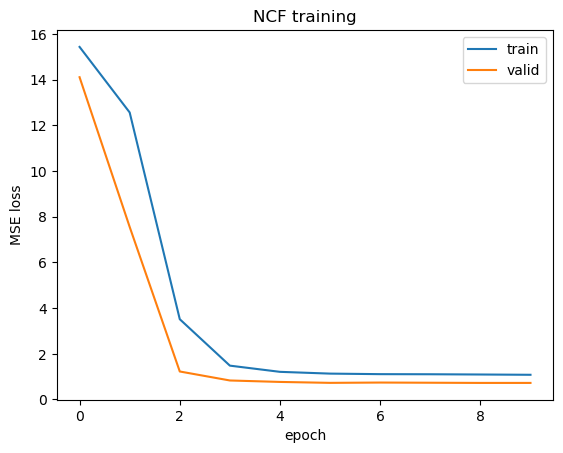

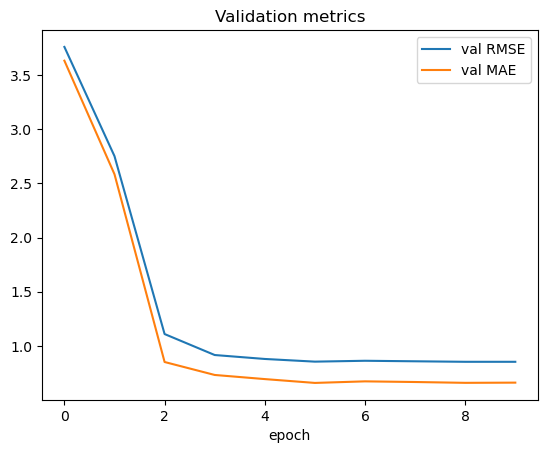

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='valid')
plt.xlabel('epoch'); plt.ylabel('MSE loss'); plt.legend(); plt.title('NCF training'); plt.show()

plt.figure()
plt.plot(history['val_rmse'], label='val RMSE'); plt.plot(history['val_mae'], label='val MAE')
plt.xlabel('Epoch'); plt.legend(); plt.title('Validation metrics'); plt.show()


In [104]:
model.load_state_dict(torch.load(model_path, map_location=device))
test_loss, test_rmse, test_mae = run_epoch(model, test_loader, criterion, optimizer=None, device=device)
print(f'Test RMSE: {test_rmse:.4f} | Test MAE: {test_mae:.4f}')


Test RMSE: 0.8884 | Test MAE: 0.6881


In [105]:
train_seen = build_seen_items(train_df)
movies_meta = pd.read_csv(PROC / 'movies_enriched.csv', usecols=['movieId', 'title', 'genres'])

sample_user = int(train_df.userId.sample(1, random_state=42).iloc[0])
topk = recommend_topk(
    model,
    sample_user,
    user2idx=user2idx_map,
    item2idx=item2idx_map,
    train_seen=train_seen,
    k=10,
    device=device,
).merge(movies_meta, on='movieId', how='left')

print('Sample user:', sample_user)
display(topk)


Sample user: 591


,movieId,score,title,genres
0,1252,4.366005,Chinatown (1974),Crime|Film-Noir|Mystery|Thriller
1,1199,4.320239,Brazil (1985),Fantasy|Sci-Fi
2,318,4.309656,"Shawshank Redemption, The (1994)",Crime|Drama
3,750,4.281291,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
4,50,4.247059,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
5,904,4.203645,Rear Window (1954),Mystery|Thriller
6,912,4.185030,Casablanca (1942),Drama|Romance
7,541,4.176995,Blade Runner (1982),Action|Sci-Fi|Thriller
8,1197,4.171471,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
9,2329,4.171195,American History X (1998),Crime|Drama
